# ML Task - Predicting LOS using window and PySpark

Start with the necessary imports...

In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lag, col, avg, hour, dayofweek, dayofmonth, month, year
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit


import matplotlib.pyplot as plt
import numpy as np


import os

Define necessary PySpark env variables.

In [2]:
#os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-17-openjdk-amd64'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-21-openjdk-21.0.3.0.9-1.fc40.x86_64/'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
os.environ['SPARK_MASTER_HOST'] = 'localhost'

Building the spark session...

In [2]:
spark = SparkSession.builder \
    .appName("Setup") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.host","127.0.0.1") \
    .config("spark.driver.bindAddress","127.0.0.1") \
    .getOrCreate()
sc = spark.sparkContext

Read the previously processed data.

In [27]:
file_path = "dataset/DS.parquet"

ds = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

ds.printSchema()
ds.show(5)

root
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- LOS: double (nullable = true)
 |-- SEQ_NUM: integer (nullable = true)
 |-- TOTAL_EVENTS: long (nullable = true)
 |-- AGE_AT_ADMISSION: integer (nullable = true)
 |-- ADMITTIME: timestamp (nullable = true)
 |-- GENDER: double (nullable = true)
 |-- ADMISSION_TYPE: double (nullable = true)
 |-- MULTIPLE_ADMISSIONS: integer (nullable = true)
 |-- MULTIPLE_ICU_STAYS: integer (nullable = true)

+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|SUBJECT_ID|HADM_ID|   LOS|SEQ_NUM|TOTAL_EVENTS|AGE_AT_ADMISSION|          ADMITTIME|GENDER|ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+----------+-------+------+-------+------------+----------------+-------------------+------+--------------+-------------------+------------------+
|       295| 192988|0.9057|      2|        1246|              61|2176-03-

In [109]:
ds.describe().show()

+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+
|summary|       SUBJECT_ID|           HADM_ID|              LOS|          SEQ_NUM|     TOTAL_EVENTS|  AGE_AT_ADMISSION|             GENDER|     ADMISSION_TYPE|MULTIPLE_ADMISSIONS|MULTIPLE_ICU_STAYS|
+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+-------------------+-------------------+------------------+
|  count|            19891|             19891|            19891|            19891|            19891|             19891|              19891|              19891|              19891|             19891|
|   mean|38194.28098134835|149954.20411241264|3.747975958976436| 8.50273993263285|5724.020360967272| 66.76144990196572|0.43426675380825497|0.23498064451259362| 0.3134080740033181|0.3832386506460208|
| std

# Models

We train and evaluate three different regression models (Linear Regression, Decision Tree Regressor and Gradient-Boosted Trees Regressor) to predict LOS.

Select the following features for our models:

In [28]:
features = ["TOTAL_EVENTS", "AGE_AT_ADMISSION", "GENDER", "ADMISSION_TYPE", "MULTIPLE_ADMISSIONS", "MULTIPLE_ICU_STAYS", "SEQ_NUM"]
target = "LOS"

The dataset is split into training and testing sets (80% training, 20% testing), and a `VectorAssembler` is used to assemble the feature columns into a single vector column named "features".

In [29]:
(train_data, test_data) = ds.randomSplit([0.8, 0.2], seed=42)

In [30]:
assembler = VectorAssembler(inputCols=features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

Applying scaling doesn't improve the performance of Decision Tree Regressor and Gradient-Boosted Trees Regressor algorithms due to the nature of the algorithms. Linear Regression improved, but not significantly. Therefore, we chose not to use feature scaling.

In [79]:
'''
# features_to_scale = ["TOTAL_EVENTS","AGE_AT_ADMISSION","SEQ_NUM"]

scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

scaler_model = scaler.fit(train_data)
train_data = scaler_model.transform(train_data)
test_data = scaler_model.transform(test_data)

train_data = train_data.drop("features")
train_data = train_data.withColumnRenamed("scaled_features", "features")

test_data = test_data.drop("features")
test_data = test_data.withColumnRenamed("scaled_features", "features")

test_data.select("features").show(5)
train_data.select("features").show(5)
'''

The models were trained with hyperparameter tuning using a parameter grid and evaluated using Root Mean Squared Error (RMSE), R-squared (R²), Mean Absolute Error (MAE), and Mean Squared Error (MSE).

For all the models, we compute and display the performance metrics and feature importances and also visualize the actual vs. predicted values using scatter plots.

### Linear regression

In [31]:
lr = LinearRegression(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .addGrid(lr.maxIter, [10, 100, 1000]) \
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# run TrainValidationSplit, and choose the best set of parameters
lr_model = tvs.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(5)

rmse_lr = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_lr}")

evaluator.setMetricName("r2")
r2_lr = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2_lr}")

evaluator.setMetricName("mae")
mae_lr = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae_lr}")

evaluator.setMetricName("mse")
mse_lr = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse_lr}")

coefficients = lr_model.bestModel.coefficients
intercept = lr_model.bestModel.intercept

print("Coefficients: {}".format(coefficients))
print("Intercept: {:.2f}".format(intercept))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+------+------------------+
|            features|   LOS|        prediction|
+--------------------+------+------------------+
|[4941.0,39.0,1.0,...| 3.666|3.2560600467409886|
|[1312.0,75.0,0.0,...|1.1862| 1.810297553043728|
|(7,[0,1,6],[3840....|3.5466|2.8241531599149265|
|[4732.0,72.0,0.0,...|4.3483| 3.323938623497771|
|(7,[0,1,6],[1407....|1.6412| 2.113869196041325|
+--------------------+------+------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 2.912560303458281
R-squared on test data = 0.6449037877894166
Mean Absolute Error (MAE) on test data = 1.6234609390119599
Mean Squared Error (MSE) on test data = 8.483007521280996
Coefficients: [0.00030660787244037155,-0.0027456145979863674,0.042164941907472595,-0.11988988428038107,1.8178807540645714,-2.154130008039341,0.1441737967985986]
Intercept: 1.23
Feature Importance:
  MULTIPLE_ICU_STAYS: 2.154
  MULTIPLE_ADMISSIONS: 1.818
  SEQ_NUM: 0.144
  ADMISSION_TYPE: 0.120
  GENDER: 0.0

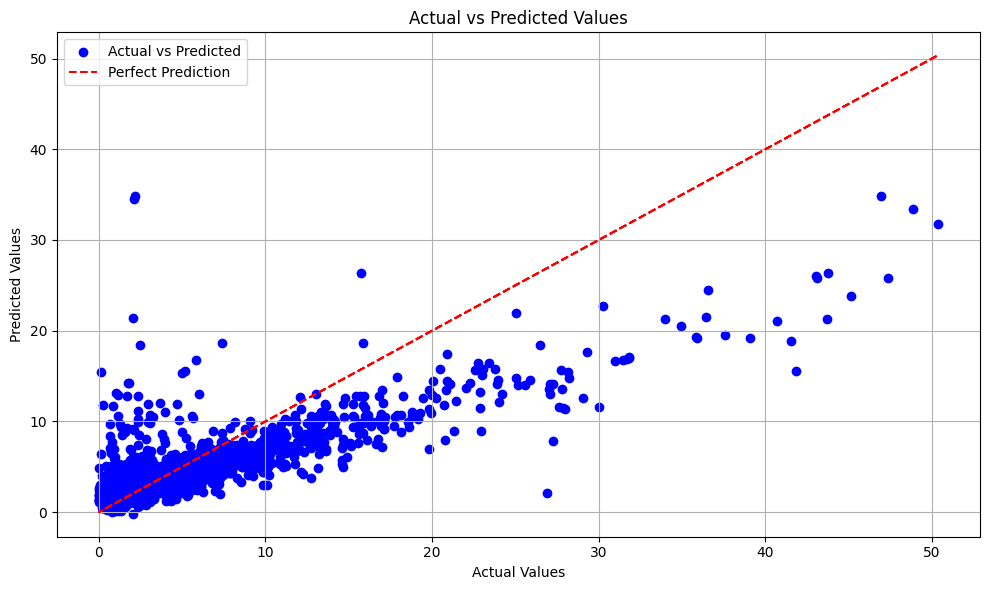

In [32]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Decision Tree Regressor

In [9]:
dt = DecisionTreeRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(dt.maxDepth, [5, 10, 15]) \
    .addGrid(dt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=dt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# run TrainValidationSplit, and choose the best set of parameters
dt_model = tvs.fit(train_data)

predictions = dt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse_dt = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_dt}")

evaluator.setMetricName("r2")
r2_dt = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2_dt}")

evaluator.setMetricName("mae")
mae_dt = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae_dt}")

evaluator.setMetricName("mse")
mse_dt = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse_dt}")

coefficients = dt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666| 4.065289782608696|
|[1312.0,75.0,0.0,...| 1.1862|1.7029758743523324|
|(7,[0,1,6],[3840....| 3.5466| 2.882551275820165|
|[4732.0,72.0,0.0,...| 4.3483| 4.173575049504955|
|(7,[0,1,6],[1407....| 1.6412|1.7029758743523324|
|[2690.0,76.0,1.0,...| 1.2469|2.2736530704589537|
|[3108.0,60.0,1.0,...| 3.0237|2.6688310828025483|
|[12627.0,75.0,1.0...|  7.128| 7.957945623342177|
|(7,[0,1,6],[5825....| 2.7712| 4.816035881104026|
|[2386.0,55.0,1.0,...|  2.036|2.2736530704589537|
|[21649.0,78.0,1.0...|15.2614|21.176407666666655|
|[1806.0,54.0,0.0,...| 2.0859|1.7029758743523324|
|[2061.0,44.0,0.0,...| 2.0667|1.7029758743523324|
|(7,[0,1,6],[3671....| 2.7446| 2.882551275820165|
|[18940.0,71.0,1.0...|12.8558|11.430938080495356|
|(7,[0,1,6],[2581....| 2.0323|2.2736530704589537|
|[1942.0,56.0,1.0,...| 1.3305| 1.299049292709468|


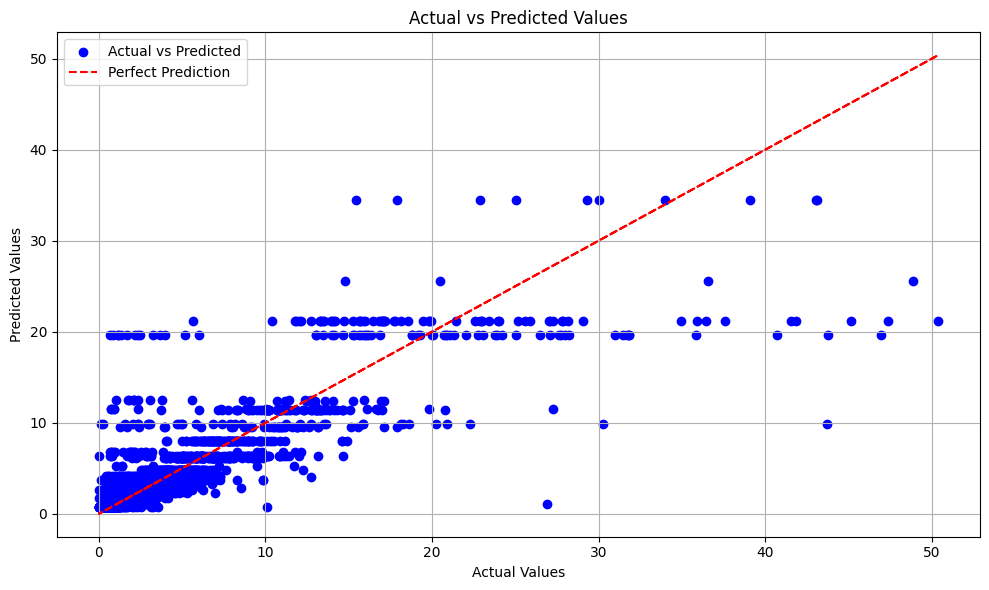

In [10]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Gradient-Boosted Trees Regressor (GBT)

In [11]:
gbt = GBTRegressor(featuresCol='features', labelCol=target)

paramGrid = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxBins, [20, 30])\
    .build()

evaluator = RegressionEvaluator(
    labelCol=target, predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=gbt,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8)

# run TrainValidationSplit, and choose the best set of parameters
gbt_model = tvs.fit(train_data)

predictions = gbt_model.transform(test_data)

predictions.select("features", "LOS", "prediction").show(20)

rmse_gbt = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse_gbt}")

evaluator.setMetricName("r2")
r2_gbt = evaluator.evaluate(predictions)
print(f"R-squared on test data = {r2_gbt}")

evaluator.setMetricName("mae")
mae_gbt = evaluator.evaluate(predictions)
print(f"Mean Absolute Error (MAE) on test data = {mae_gbt}")

evaluator.setMetricName("mse")
mse_gbt = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE) on test data = {mse_gbt}")

coefficients = gbt_model.bestModel.featureImportances

print("Coefficients: {}".format(coefficients))

feature_importance = sorted(list(zip(features, map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

+--------------------+-------+------------------+
|            features|    LOS|        prediction|
+--------------------+-------+------------------+
|[4941.0,39.0,1.0,...|  3.666|3.9050676144369385|
|[1312.0,75.0,0.0,...| 1.1862|1.5948523289520795|
|(7,[0,1,6],[3840....| 3.5466| 2.810357888988774|
|[4732.0,72.0,0.0,...| 4.3483|  3.69151064267232|
|(7,[0,1,6],[1407....| 1.6412|1.5180131079073145|
|[2690.0,76.0,1.0,...| 1.2469|1.8565580084651323|
|[3108.0,60.0,1.0,...| 3.0237| 2.946973429924087|
|[12627.0,75.0,1.0...|  7.128| 8.267580519331224|
|(7,[0,1,6],[5825....| 2.7712|4.0593930352137395|
|[2386.0,55.0,1.0,...|  2.036| 2.382742083046234|
|[21649.0,78.0,1.0...|15.2614| 13.83915012808115|
|[1806.0,54.0,0.0,...| 2.0859|1.7345486663320713|
|[2061.0,44.0,0.0,...| 2.0667|1.9133603820389649|
|(7,[0,1,6],[3671....| 2.7446| 2.941420457446949|
|[18940.0,71.0,1.0...|12.8558|14.578197822407931|
|(7,[0,1,6],[2581....| 2.0323| 2.164553581496812|
|[1942.0,56.0,1.0,...| 1.3305|1.3023384010013117|


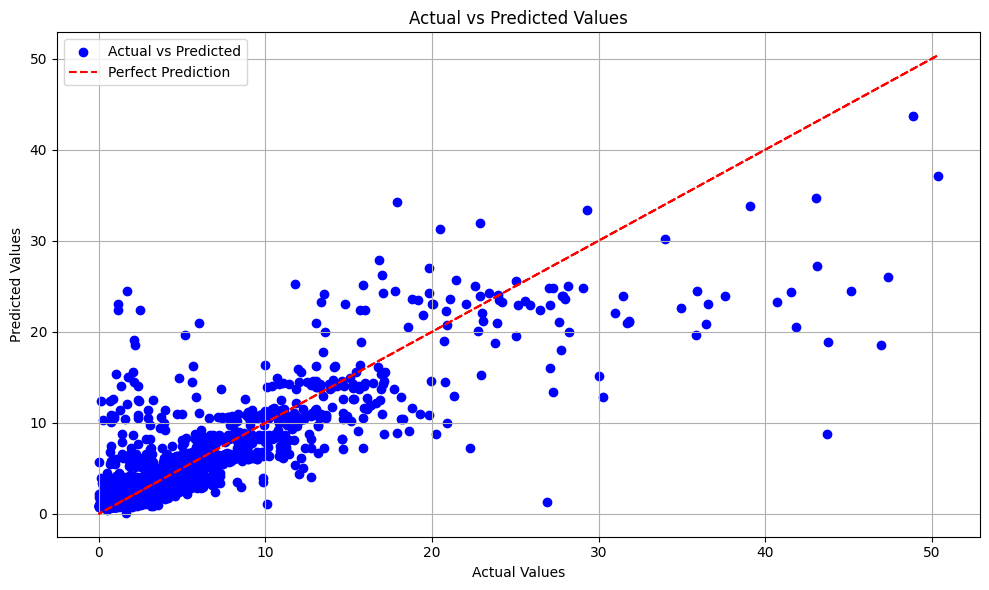

In [12]:
results = predictions.select(['prediction', target]).toPandas()

actual = results[target]
predicted = results['prediction']

plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, color='blue', label='Actual vs Predicted')
plt.plot(actual, actual, color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusion

Gradient-Boosted Trees Regressor has the highest R², followed closely by the Decision Tree Regressor, and then Linear Regression. This suggests that the DT and GBT models explain more variance in the data compared to Linear Regression.

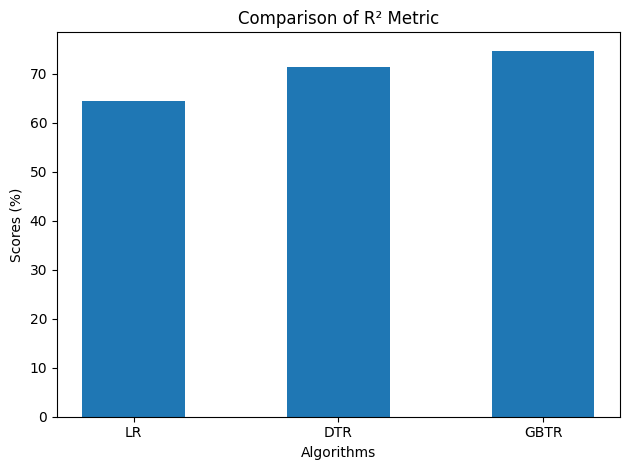

In [33]:
r2 = [r2_lr*100, r2_dt*100, r2_gbt*100]

labels = ['LR', 'DTR', 'GBTR']

x = np.arange(len(labels))

plt.bar(x, r2, width=0.5, label='R²')

plt.xlabel('Algorithms')
plt.ylabel('Scores (%)')
plt.title('Comparison of R² Metric')

plt.xticks(x, labels)
plt.tight_layout()
plt.show()

GBT Regressor consistently outperforms both Linear Regression and Decision Tree Regressor across all metrics.

Decision Tree Regressor generally performs better than Linear Regression but not as well as GBT Regressor.

Linear Regression shows the weakest performance among the three models.

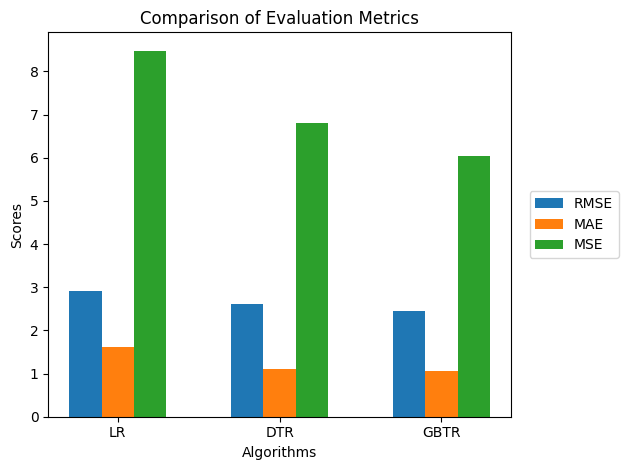

In [26]:
rmse = [rmse_lr, rmse_dt, rmse_gbt]
mae = [mae_lr, mae_dt, mae_gbt]
mse = [mse_lr, mse_dt, mse_gbt]

labels = ['LR', 'DTR', 'GBTR']
bar_width = 0.2

x = np.arange(len(labels))

plt.bar(x - bar_width, rmse, width=bar_width, label='RMSE')
plt.bar(x, mae, width=bar_width, label='MAE')
plt.bar(x + bar_width, mse, width=bar_width, label='MSE')

plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.title('Comparison of Evaluation Metrics')

plt.xticks(x, labels)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.tight_layout()
plt.show()